**Thư viện cần thiết**

In [1]:
import os
import torch
import torch.nn as nn
from PIL import Image
import numpy as np
from tqdm import tqdm
import glob
import torchvision.transforms as T
import os
import glob
import numpy as np
from tqdm import tqdm
from PIL import Image
from torch.utils.data import Dataset, DataLoader

import yaml
import os
import glob
import numpy as np
import torch
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as T
import torch.nn.functional as F


Khởi tọa lớp chuẩn hóa

In [2]:


class RGBDToRGBDataset(torch.utils.data.Dataset):
    def __init__(self, rgb_dir, depth_dir, transform=None, max_depth=100.0):
        self.rgb_dir = rgb_dir
        self.depth_dir = depth_dir
        self.transform = transform
        self.max_depth = max_depth

        # Tìm tất cả ảnh
        self.rgb_files = sorted(glob.glob(os.path.join(rgb_dir, "*.png")))
        self.depth_files = sorted(glob.glob(os.path.join(depth_dir, "*.png")))

        # Khớp tên file
        rgb_names = {os.path.splitext(os.path.basename(f))[0] for f in self.rgb_files}
        depth_names = {os.path.splitext(os.path.basename(f))[0] for f in self.depth_files}
        self.common_names = sorted(rgb_names & depth_names)

        if not self.common_names:
            raise ValueError("❌ Không tìm thấy cặp RGB-Depth nào!")

    def __len__(self):
        return len(self.common_names)

    def load_rgb(self, path):
        img = Image.open(path).convert('RGB')
        img = np.array(img).astype(np.float32) / 255.0
        return img

    def load_depth(self, path):
        depth = np.array(Image.open(path)).astype(np.float32)
        depth = depth / 65535.0 * self.max_depth
        depth = np.log1p(depth)
        depth = (depth - depth.min()) / (depth.max() - depth.min() + 1e-6)
        return depth[..., np.newaxis]

    def __getitem__(self, idx):
        if idx >= len(self.common_names):
            raise IndexError(f"Index {idx} out of range for {len(self.common_names)} samples.")

        name = self.common_names[idx]
        rgb_path = os.path.join(self.rgb_dir, f"{name}.png")
        depth_path = os.path.join(self.depth_dir, f"{name}.png")

        rgb = self.load_rgb(rgb_path)
        depth = self.load_depth(depth_path)

        rgbd = np.concatenate([rgb, depth], axis=-1)

        if self.transform:
            rgbd = self.transform(Image.fromarray((rgbd * 255).astype(np.uint8)))
            rgb = self.transform(Image.fromarray((rgb * 255).astype(np.uint8)))
        else:
            rgbd = torch.from_numpy(rgbd).permute(2, 0, 1).float()
            rgb = torch.from_numpy(rgb).permute(2, 0, 1).float()

        return rgbd, rgb


**Loading file dữ liệu dạng zip**

In [3]:
!unzip /content/drive/MyDrive/Processed_KITTI.zip -d /content/extracted

Streaming output truncated to the last 5000 lines.
  inflating: /content/extracted/train/labels/000663.txt  
  inflating: /content/extracted/train/labels/001328.txt  
  inflating: /content/extracted/train/labels/003267.txt  
  inflating: /content/extracted/train/labels/003549.txt  
  inflating: /content/extracted/train/labels/000095.txt  
  inflating: /content/extracted/train/labels/002505.txt  
  inflating: /content/extracted/train/labels/007384.txt  
  inflating: /content/extracted/train/labels/001879.txt  
  inflating: /content/extracted/train/labels/004520.txt  
  inflating: /content/extracted/train/labels/007162.txt  
  inflating: /content/extracted/train/labels/003762.txt  
  inflating: /content/extracted/train/labels/007170.txt  
  inflating: /content/extracted/train/labels/000175.txt  
  inflating: /content/extracted/train/labels/004143.txt  
  inflating: /content/extracted/train/labels/006723.txt  
  inflating: /content/extracted/train/labels/004184.txt  
  inflating: /content

In [ ]:
class RGBDAdapter(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(4, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 3, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(3)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.relu(self.bn3(self.conv3(x)))
        return x


In [ ]:

# Hyperparams
num_epochs = 20
batch_size = 16
lr = 1e-3
lambda_div = 0.1
# Dataset
transform = T.Compose([
    T.Resize((384, 1248)),
    T.ColorJitter(brightness=0.2, contrast=0.2)
    T.RandomHorizontalFlip()
    T.ToTensor(),
])
train_dataset = RGBDToRGBDataset(
    rgb_dir="/content/extracted/train/rgb",
    depth_dir="/content/extracted/train/depth",
    transform=transform
)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2,pin_memory=True)



In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
adapter = RGBDAdapter().to(device)
optimizer = torch.optim.Adam(adapter.parameters(), lr=lr)
loss_fn_recon = nn.L1Loss()
loss_fn_div = nn.L1Loss()

# =========================
# 8️⃣ TRAINING LOOP
# =========================
for epoch in range(num_epochs):
    adapter.train()
    total_loss = 0
    for rgbd, target_rgb in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        rgbd = rgbd.to(device)
        target_rgb = target_rgb.to(device)

        optimizer.zero_grad()
        output = adapter(rgbd)

        loss_recon = loss_fn_recon(output, target_rgb)
        loss_div = loss_fn_div(output, rgbd[:, :3])
        loss = loss_recon + lambda_div * loss_div

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"✅ Epoch {epoch+1}: Loss={avg_loss:.4f}")

# =========================
# 9️⃣ SAVE BEST MODEL
# =========================
save_path = "/content/drive/MyDrive/Khóa Luận/Data_Object/Processed_KITTI/best_adapter.pt"
torch.save(adapter.state_dict(), save_path)
print(f"✅ Adapter saved at {save_path}")

Epoch 1/20: 100%|██████████| 421/421 [09:11<00:00,  1.31s/it]


✅ Epoch 1: Loss=0.0843


Epoch 2/20: 100%|██████████| 421/421 [09:19<00:00,  1.33s/it]


✅ Epoch 2: Loss=0.0541


Epoch 3/20: 100%|██████████| 421/421 [09:20<00:00,  1.33s/it]


✅ Epoch 3: Loss=0.0461


Epoch 4/20: 100%|██████████| 421/421 [09:22<00:00,  1.34s/it]


✅ Epoch 4: Loss=0.0391


Epoch 5/20: 100%|██████████| 421/421 [09:18<00:00,  1.33s/it]


✅ Epoch 5: Loss=0.0334


Epoch 6/20: 100%|██████████| 421/421 [09:07<00:00,  1.30s/it]


✅ Epoch 6: Loss=0.0292


Epoch 7/20: 100%|██████████| 421/421 [09:21<00:00,  1.33s/it]


✅ Epoch 7: Loss=0.0258


Epoch 8/20: 100%|██████████| 421/421 [09:22<00:00,  1.34s/it]


✅ Epoch 8: Loss=0.0246


Epoch 9/20: 100%|██████████| 421/421 [09:27<00:00,  1.35s/it]


✅ Epoch 9: Loss=0.0227


Epoch 10/20: 100%|██████████| 421/421 [09:14<00:00,  1.32s/it]


✅ Epoch 10: Loss=0.0220


Epoch 11/20: 100%|██████████| 421/421 [09:07<00:00,  1.30s/it]


✅ Epoch 11: Loss=0.0217


Epoch 12/20: 100%|██████████| 421/421 [09:16<00:00,  1.32s/it]


✅ Epoch 12: Loss=0.0214


Epoch 13/20: 100%|██████████| 421/421 [09:11<00:00,  1.31s/it]


✅ Epoch 13: Loss=0.0209


Epoch 14/20: 100%|██████████| 421/421 [09:16<00:00,  1.32s/it]


✅ Epoch 14: Loss=0.0204


Epoch 15/20: 100%|██████████| 421/421 [09:24<00:00,  1.34s/it]


✅ Epoch 15: Loss=0.0204


Epoch 16/20: 100%|██████████| 421/421 [09:16<00:00,  1.32s/it]


✅ Epoch 16: Loss=0.0196


Epoch 17/20: 100%|██████████| 421/421 [09:33<00:00,  1.36s/it]


✅ Epoch 17: Loss=0.0190


Epoch 18/20: 100%|██████████| 421/421 [09:18<00:00,  1.33s/it]


✅ Epoch 18: Loss=0.0185


Epoch 19/20: 100%|██████████| 421/421 [09:22<00:00,  1.34s/it]


✅ Epoch 19: Loss=0.0179


Epoch 20/20: 100%|██████████| 421/421 [09:22<00:00,  1.34s/it]


✅ Epoch 20: Loss=0.0186
✅ Adapter saved at /content/drive/MyDrive/Khóa Luận/Data_Object/Processed_KITTI/best_adapter.pt


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
adapter = RGBDAdapter().to(device)
adapter.load_state_dict(torch.load("/content/drive/MyDrive/Khóa Luận/Data_Object/Processed_KITTI/best_adapter.pt"))
adapter.eval()
print("✅ Adapter loaded")


✅ Adapter loaded


In [ ]:

# Thông số
max_depth = 100.0
resize_shape = (384, 1248)

# Transform giống lúc train
transform = T.Compose([
    T.Resize(resize_shape),
    T.ToTensor()
])

def load_rgb_image(path):
    img = Image.open(path).convert('RGB')
    img = np.array(img).astype(np.float32) / 255.0
    return img

def load_depth_image(path):
    depth = np.array(Image.open(path)).astype(np.float32)
    depth = depth / 65535.0 * max_depth
    depth = np.log1p(depth)
    depth = (depth - depth.min()) / (depth.max() - depth.min() + 1e-6)
    return depth[..., np.newaxis]


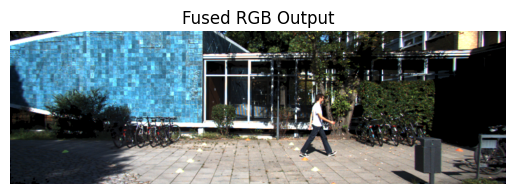

In [ ]:
import matplotlib.pyplot as plt
import torch

def fuse_single_image(rgb_path, depth_path):
    rgb = load_rgb_image(rgb_path)
    depth = load_depth_image(depth_path)
    rgbd = np.concatenate([rgb, depth], axis=-1)

    rgbd_tensor = transform(Image.fromarray((rgbd*255).astype(np.uint8)))
    rgbd_tensor = rgbd_tensor.unsqueeze(0).to(device)

    with torch.no_grad():
        fused_tensor = adapter(rgbd_tensor)
        fused_tensor = fused_tensor.squeeze(0).cpu().clamp(0,1)

    fused_image = (fused_tensor.permute(1,2,0).numpy() * 255).astype(np.uint8)
    return fused_image

# ✅ Ví dụ dùng
rgb_test_path = "/content/extracted/train/rgb/000000.png"
depth_test_path = "/content/extracted/train/depth/000000.png"

fused = fuse_single_image(rgb_test_path, depth_test_path)

plt.imshow(fused)
plt.title("Fused RGB Output")
plt.axis('off')
plt.show()


In [ ]:
import glob

print("abc")
INPUT_RGB_DIR = "/content/extracted/train/rgb/"
INPUT_DEPTH_DIR = "/content/extracted/train/depth/"
OUTPUT_FUSED_DIR = "/content/drive/MyDrive/Khóa Luận/Data_Object/Processed_KITTI/Data_RGBD/train/fused_images_train/"

os.makedirs(OUTPUT_FUSED_DIR, exist_ok=True)

rgb_files = sorted(glob.glob(os.path.join(INPUT_RGB_DIR, "*.png")))
depth_files = sorted(glob.glob(os.path.join(INPUT_DEPTH_DIR, "*.png")))
common_names = sorted({
    os.path.splitext(os.path.basename(f))[0]
    for f in rgb_files
} & {
    os.path.splitext(os.path.basename(f))[0]
    for f in depth_files
})

print(f"✅ Found {len(common_names)} image pairs to process")

for name in tqdm(common_names, desc="Generating Fused Images"):
    rgb_path = os.path.join(INPUT_RGB_DIR, f"{name}.png")
    depth_path = os.path.join(INPUT_DEPTH_DIR, f"{name}.png")
    out_path = os.path.join(OUTPUT_FUSED_DIR, f"{name}.png")

    fused = fuse_single_image(rgb_path, depth_path)
    Image.fromarray(fused).save(out_path)

abc
✅ Found 6732 image pairs to process


Generating Fused Images:  10%|█         | 676/6732 [08:56<1:17:19,  1.31it/s]

Thử cải thiện


*   Về data aug
*   Skip Conection
*   Thay đổi hàm loss
*   Clamp





In [ ]:
!pip install piq
import piq



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.9/106.9 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 116.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 42.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



NameError: name 'piq' is not defined

In [ ]:
import torch
import torch.nn.functional as F

def ssim_loss(pred, target, window_size=3, C1=0.01**2, C2=0.03**2):
    """
    pred, target: shape [B, C, H, W], values in [0, 1]
    """
    mu_pred = F.avg_pool2d(pred, window_size, 1, window_size // 2)
    mu_target = F.avg_pool2d(target, window_size, 1, window_size // 2)

    mu_pred_sq = mu_pred.pow(2)
    mu_target_sq = mu_target.pow(2)
    mu_pred_target = mu_pred * mu_target

    sigma_pred = F.avg_pool2d(pred * pred, window_size, 1, window_size // 2) - mu_pred_sq
    sigma_target = F.avg_pool2d(target * target, window_size, 1, window_size // 2) - mu_target_sq
    sigma_pred_target = F.avg_pool2d(pred * target, window_size, 1, window_size // 2) - mu_pred_target

    ssim_n = (2 * mu_pred_target + C1) * (2 * sigma_pred_target + C2)
    ssim_d = (mu_pred_sq + mu_target_sq + C1) * (sigma_pred + sigma_target + C2)

    ssim_map = ssim_n / (ssim_d + 1e-7)
    loss = torch.clamp((1 - ssim_map) / 2, 0, 1)
    return loss.mean()


NameError: name 'pred' is not defined

In [ ]:
class RGBDAdapter(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(4, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 3, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(3)
        self.relu = nn.ReLU()

    def forward(self, x):
        rgb = x[:, :3, :, :]
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.relu(self.bn2(self.conv2(out)))
        out = self.relu(self.bn3(self.conv3(out)))
        out = out + rgb
        return torch.clamp(out, 0, 1)

In [ ]:
loss_fn_recon = nn.L1Loss()
loss_fn_div = nn.L1Loss()


In [ ]:

# Hyperparams
num_epochs = 20
batch_size = 8
lr = 1e-3
# Dataset
transform = T.Compose([
    T.Resize((384, 1248)),
    T.ColorJitter(brightness=0.2, contrast=0.2),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
])
train_dataset = RGBDToRGBDataset(
    rgb_dir="/content/extracted/train/rgb",
    depth_dir="/content/extracted/train/depth",
    transform=transform
)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4,pin_memory=True)



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
alpha = 0.8
beta = 0.2
adapter = RGBDAdapter().to(device)
optimizer = torch.optim.Adam(adapter.parameters(), lr=lr)

alpha = 0.8
beta = 0.2

for epoch in range(num_epochs):
    adapter.train()
    total_epoch_loss = 0

    for rgbd, target_rgb in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        rgbd = rgbd.to(device)
        target_rgb = target_rgb.to(device)

        optimizer.zero_grad()
        output = adapter(rgbd)

        loss_l1 = F.l1_loss(output, target_rgb)
        loss_ssim = ssim_loss(output, target_rgb)

        loss = alpha * loss_l1 + beta * loss_ssim

        loss.backward()
        optimizer.step()

        total_epoch_loss += loss.item()

    avg_epoch_loss = total_epoch_loss / len(train_loader)
    print(f"✅ Epoch {epoch+1}: Average Loss = {avg_epoch_loss:.4f}")

save_path = "/content/drive/MyDrive/Khóa Luận/Data_Object/Processed_KITTI/best_adapter_v2.pt"
torch.save(adapter.state_dict(), save_path)
print(f"✅ Adapter saved at {save_path}")

Epoch 1/20:   0%|          | 0/842 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 1/20: 100%|██████████| 842/842 [13:26<00:00,  1.04it/s]


✅ Epoch 1: Average Loss = 0.1848


Epoch 2/20:   0%|          | 0/842 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 2/20: 100%|██████████| 842/842 [14:17<00:00,  1.02s/it]


✅ Epoch 2: Average Loss = 0.1790


Epoch 3/20: 100%|██████████| 842/842 [15:00<00:00,  1.07s/it]


✅ Epoch 3: Average Loss = 0.1755


Epoch 4/20:   0%|          | 0/842 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 4/20: 100%|██████████| 842/842 [15:15<00:00,  1.09s/it]


✅ Epoch 4: Average Loss = 0.1791


Epoch 5/20:   0%|          | 0/842 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 5/20: 100%|██████████| 842/842 [14:57<00:00,  1.07s/it]


✅ Epoch 5: Average Loss = 0.1790


Epoch 6/20: 100%|██████████| 842/842 [15:19<00:00,  1.09s/it]


✅ Epoch 6: Average Loss = 0.1770


Epoch 7/20:   0%|          | 0/842 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 7/20: 100%|██████████| 842/842 [15:16<00:00,  1.09s/it]


✅ Epoch 7: Average Loss = 0.1812


Epoch 8/20: 100%|██████████| 842/842 [15:22<00:00,  1.10s/it]


✅ Epoch 8: Average Loss = 0.1791


Epoch 9/20: 100%|██████████| 842/842 [15:37<00:00,  1.11s/it]


✅ Epoch 9: Average Loss = 0.1769


Epoch 10/20: 100%|██████████| 842/842 [15:17<00:00,  1.09s/it]


✅ Epoch 10: Average Loss = 0.1764


Epoch 11/20: 100%|██████████| 842/842 [15:05<00:00,  1.08s/it]


✅ Epoch 11: Average Loss = 0.1789


Epoch 12/20:   0%|          | 0/842 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 12/20: 100%|██████████| 842/842 [15:23<00:00,  1.10s/it]


✅ Epoch 12: Average Loss = 0.1819


Epoch 13/20:   0%|          | 0/842 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 13/20: 100%|██████████| 842/842 [15:16<00:00,  1.09s/it]


✅ Epoch 13: Average Loss = 0.1770


Epoch 14/20:   1%|          | 8/842 [00:10<17:37,  1.27s/it]


KeyboardInterrupt: 

In [ ]:
save_path = "/content/drive/MyDrive/Khóa Luận/Data_Object/Processed_KITTI/best_adapter_v2.pt"
torch.save(adapter.state_dict(), save_path)
print(f"✅ Adapter saved at {save_path}")

✅ Adapter saved at /content/drive/MyDrive/Khóa Luận/Data_Object/Processed_KITTI/best_adapter_v2.pt


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
adapter = RGBDAdapter().to(device)
adapter.load_state_dict(torch.load("/content/drive/MyDrive/Khóa Luận/Data_Object/Processed_KITTI/best_adapter_v2.pt"))
adapter.eval()
print("✅ Adapter loaded")


✅ Adapter loaded


In [ ]:

# Thông số
max_depth = 100.0
resize_shape = (384, 1248)

# Transform giống lúc train
transform = T.Compose([
    T.Resize(resize_shape),
    T.ToTensor()
])

def load_rgb_image(path):
    img = Image.open(path).convert('RGB')
    img = np.array(img).astype(np.float32) / 255.0
    return img

def load_depth_image(path):
    depth = np.array(Image.open(path)).astype(np.float32)
    depth = depth / 65535.0 * max_depth
    depth = np.log1p(depth)
    depth = (depth - depth.min()) / (depth.max() - depth.min() + 1e-6)
    return depth[..., np.newaxis]


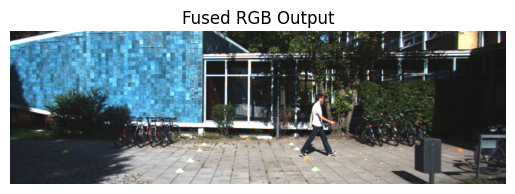

In [ ]:
import matplotlib.pyplot as plt
import torch

def fuse_single_image(rgb_path, depth_path):
    rgb = load_rgb_image(rgb_path)
    depth = load_depth_image(depth_path)
    rgbd = np.concatenate([rgb, depth], axis=-1)

    rgbd_tensor = transform(Image.fromarray((rgbd*255).astype(np.uint8)))
    rgbd_tensor = rgbd_tensor.unsqueeze(0).to(device)

    with torch.no_grad():
        fused_tensor = adapter(rgbd_tensor)
        fused_tensor = fused_tensor.squeeze(0).cpu().clamp(0,1)

    fused_image = (fused_tensor.permute(1,2,0).numpy() * 255).astype(np.uint8)
    return fused_image

# ✅ Ví dụ dùng
rgb_test_path = "/content/extracted/train/rgb/000000.png"
depth_test_path = "/content/extracted/train/depth/000000.png"

fused = fuse_single_image(rgb_test_path, depth_test_path)

plt.imshow(fused)
plt.title("Fused RGB Output")
plt.axis('off')
plt.show()


In [ ]:
import glob

print("abc")
INPUT_RGB_DIR = "/content/extracted/train/rgb/"
INPUT_DEPTH_DIR = "/content/extracted/train/depth/"
OUTPUT_FUSED_DIR = "/content/drive/MyDrive/Khóa Luận/Data_Object/Processed_KITTI/fused_images_train_v2/"

os.makedirs(OUTPUT_FUSED_DIR, exist_ok=True)

rgb_files = sorted(glob.glob(os.path.join(INPUT_RGB_DIR, "*.png")))
depth_files = sorted(glob.glob(os.path.join(INPUT_DEPTH_DIR, "*.png")))
common_names = sorted({
    os.path.splitext(os.path.basename(f))[0]
    for f in rgb_files
} & {
    os.path.splitext(os.path.basename(f))[0]
    for f in depth_files
})

print(f"✅ Found {len(common_names)} image pairs to process")

for name in tqdm(common_names, desc="Generating Fused Images"):
    rgb_path = os.path.join(INPUT_RGB_DIR, f"{name}.png")
    depth_path = os.path.join(INPUT_DEPTH_DIR, f"{name}.png")
    out_path = os.path.join(OUTPUT_FUSED_DIR, f"{name}.png")

    fused = fuse_single_image(rgb_path, depth_path)
    Image.fromarray(fused).save(out_path)

abc
✅ Found 6732 image pairs to process


Generating Fused Images: 100%|██████████| 6732/6732 [45:38<00:00,  2.46it/s]


In [ ]:
import glob

print("abc")
INPUT_RGB_DIR = "/content/extracted/val/rgb/"
INPUT_DEPTH_DIR = "/content/extracted/val/depth/"
OUTPUT_FUSED_DIR = "/content/drive/MyDrive/Khóa Luận/Data_Object/Processed_KITTI/fused_images_val_v2/"

os.makedirs(OUTPUT_FUSED_DIR, exist_ok=True)

rgb_files = sorted(glob.glob(os.path.join(INPUT_RGB_DIR, "*.png")))
depth_files = sorted(glob.glob(os.path.join(INPUT_DEPTH_DIR, "*.png")))
common_names = sorted({
    os.path.splitext(os.path.basename(f))[0]
    for f in rgb_files
} & {
    os.path.splitext(os.path.basename(f))[0]
    for f in depth_files
})

print(f"✅ Found {len(common_names)} image pairs to process")

for name in tqdm(common_names, desc="Generating Fused Images"):
    rgb_path = os.path.join(INPUT_RGB_DIR, f"{name}.png")
    depth_path = os.path.join(INPUT_DEPTH_DIR, f"{name}.png")
    out_path = os.path.join(OUTPUT_FUSED_DIR, f"{name}.png")

    fused = fuse_single_image(rgb_path, depth_path)
    Image.fromarray(fused).save(out_path)

abc
✅ Found 749 image pairs to process


Generating Fused Images:  98%|█████████▊| 733/749 [04:08<00:04,  3.29it/s]

**Thực nghiệm lần 3**

In [4]:
import torch
import torch.nn.functional as F

def ssim_loss(pred, target, window_size=3, C1=0.01**2, C2=0.03**2):
    """
    pred, target: shape [B, C, H, W], values in [0, 1]
    """
    mu_pred = F.avg_pool2d(pred, window_size, 1, window_size // 2)
    mu_target = F.avg_pool2d(target, window_size, 1, window_size // 2)

    mu_pred_sq = mu_pred.pow(2)
    mu_target_sq = mu_target.pow(2)
    mu_pred_target = mu_pred * mu_target

    sigma_pred = F.avg_pool2d(pred * pred, window_size, 1, window_size // 2) - mu_pred_sq
    sigma_target = F.avg_pool2d(target * target, window_size, 1, window_size // 2) - mu_target_sq
    sigma_pred_target = F.avg_pool2d(pred * target, window_size, 1, window_size // 2) - mu_pred_target

    ssim_n = (2 * mu_pred_target + C1) * (2 * sigma_pred_target + C2)
    ssim_d = (mu_pred_sq + mu_target_sq + C1) * (sigma_pred + sigma_target + C2)

    ssim_map = ssim_n / (ssim_d + 1e-7)
    loss = torch.clamp((1 - ssim_map) / 2, 0, 1)
    return loss.mean()


In [9]:
loss_fn_recon = nn.L1Loss()
loss_fn_div = nn.L1Loss()

# Hyperparams
num_epochs = 20
batch_size = 8
lr = 1e-3
# Dataset
transform = T.Compose([
    T.Resize((384, 1248)),
    T.ColorJitter(brightness=0.2, contrast=0.2),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
])
train_dataset = RGBDToRGBDataset(
    rgb_dir="/content/extracted/train/rgb",
    depth_dir="/content/extracted/train/depth",
    transform=transform
)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2,pin_memory=True)



In [6]:
class RGBDAdapter(nn.Module):
    def __init__(self):
        super().__init__()
        self.relu = nn.ReLU()

        # 5 tầng Conv
        self.conv1 = nn.Conv2d(4, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)

        self.conv2 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(16)

        self.conv4 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(8)

        self.conv5 = nn.Conv2d(8, 3, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(3)

    def forward(self, x):
        rgb = x[:, :3, :, :]  # giữ lại ảnh RGB gốc để skip

        out = self.relu(self.bn1(self.conv1(x)))
        out = self.relu(self.bn2(self.conv2(out)))
        out = self.relu(self.bn3(self.conv3(out)))
        out = self.relu(self.bn4(self.conv4(out)))
        out = self.relu(self.bn5(self.conv5(out)))

        # Skip connection với ảnh RGB
        out = out + rgb

        # Clamp để giữ pixel từ 0–1
        return torch.clamp(out, 0, 1)


In [10]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
alpha = 0.8
beta = 0.2

adapter = RGBDAdapter().to(device)
optimizer = torch.optim.Adam(adapter.parameters(), lr=lr)

best_loss = float('inf')
no_improve_count = 0
early_stop_patience = 3

for epoch in range(num_epochs):
    adapter.train()
    total_epoch_loss = 0

    for rgbd, target_rgb in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        rgbd = rgbd.to(device)
        target_rgb = target_rgb.to(device)

        optimizer.zero_grad()
        output = adapter(rgbd)

        loss_l1 = F.l1_loss(output, target_rgb)
        loss_ssim = ssim_loss(output, target_rgb)

        loss = alpha * loss_l1 + beta * loss_ssim

        loss.backward()
        optimizer.step()

        total_epoch_loss += loss.item()

    avg_epoch_loss = total_epoch_loss / len(train_loader)
    print(f"✅ Epoch {epoch+1}: Average Loss = {avg_epoch_loss:.4f}")

    # Early stopping check
    if avg_epoch_loss < best_loss - 1e-4:  # consider a tiny tolerance
        best_loss = avg_epoch_loss
        no_improve_count = 0

        # Save best model immediately
        save_path = "/content/drive/MyDrive/Khóa Luận/Data_Object/Processed_KITTI/best_adapter_v2.pt"
        torch.save(adapter.state_dict(), save_path)
        print(f"✅ Improvement! Saved Adapter at {save_path}")

    else:
        no_improve_count += 1
        print(f"⚠️ No improvement count: {no_improve_count}/{early_stop_patience}")

    if no_improve_count >= early_stop_patience:
        print("🛑 Early stopping triggered! No improvement in 3 epochs.")
        break


Epoch 1/20: 100%|██████████| 842/842 [12:51<00:00,  1.09it/s]


✅ Epoch 1: Average Loss = 0.1824
✅ Improvement! Saved Adapter at /content/drive/MyDrive/Khóa Luận/Data_Object/Processed_KITTI/best_adapter_v2.pt


Epoch 2/20: 100%|██████████| 842/842 [13:06<00:00,  1.07it/s]


✅ Epoch 2: Average Loss = 0.1838
⚠️ No improvement count: 1/3


Epoch 3/20: 100%|██████████| 842/842 [13:01<00:00,  1.08it/s]


✅ Epoch 3: Average Loss = 0.1812
✅ Improvement! Saved Adapter at /content/drive/MyDrive/Khóa Luận/Data_Object/Processed_KITTI/best_adapter_v2.pt


Epoch 4/20: 100%|██████████| 842/842 [12:45<00:00,  1.10it/s]


✅ Epoch 4: Average Loss = 0.1765
✅ Improvement! Saved Adapter at /content/drive/MyDrive/Khóa Luận/Data_Object/Processed_KITTI/best_adapter_v2.pt


Epoch 5/20: 100%|██████████| 842/842 [12:56<00:00,  1.08it/s]


✅ Epoch 5: Average Loss = 0.1786
⚠️ No improvement count: 1/3


Epoch 6/20: 100%|██████████| 842/842 [12:51<00:00,  1.09it/s]


✅ Epoch 6: Average Loss = 0.1802
⚠️ No improvement count: 2/3


Epoch 7/20: 100%|██████████| 842/842 [12:52<00:00,  1.09it/s]

✅ Epoch 7: Average Loss = 0.1796
⚠️ No improvement count: 3/3
🛑 Early stopping triggered! No improvement in 3 epochs.


In [11]:

# Thông số
max_depth = 100.0
resize_shape = (384, 1248)

# Transform giống lúc train
transform = T.Compose([
    T.Resize(resize_shape),
    T.ToTensor()
])

def load_rgb_image(path):
    img = Image.open(path).convert('RGB')
    img = np.array(img).astype(np.float32) / 255.0
    return img

def load_depth_image(path):
    depth = np.array(Image.open(path)).astype(np.float32)
    depth = depth / 65535.0 * max_depth
    depth = np.log1p(depth)
    depth = (depth - depth.min()) / (depth.max() - depth.min() + 1e-6)
    return depth[..., np.newaxis]


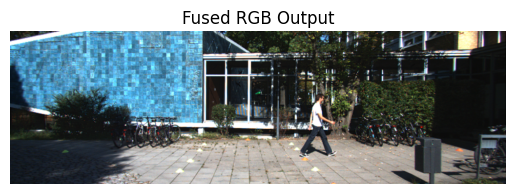

In [12]:
import matplotlib.pyplot as plt
import torch

def fuse_single_image(rgb_path, depth_path):
    rgb = load_rgb_image(rgb_path)
    depth = load_depth_image(depth_path)
    rgbd = np.concatenate([rgb, depth], axis=-1)

    rgbd_tensor = transform(Image.fromarray((rgbd*255).astype(np.uint8)))
    rgbd_tensor = rgbd_tensor.unsqueeze(0).to(device)

    with torch.no_grad():
        fused_tensor = adapter(rgbd_tensor)
        fused_tensor = fused_tensor.squeeze(0).cpu().clamp(0,1)

    fused_image = (fused_tensor.permute(1,2,0).numpy() * 255).astype(np.uint8)
    return fused_image

# ✅ Ví dụ dùng
rgb_test_path = "/content/extracted/train/rgb/000000.png"
depth_test_path = "/content/extracted/train/depth/000000.png"

fused = fuse_single_image(rgb_test_path, depth_test_path)

plt.imshow(fused)
plt.title("Fused RGB Output")
plt.axis('off')
plt.show()


In [13]:
import glob

print("abc")
INPUT_RGB_DIR = "/content/extracted/train/rgb/"
INPUT_DEPTH_DIR = "/content/extracted/train/depth/"
OUTPUT_FUSED_DIR = "/content/drive/MyDrive/Khóa Luận/Data_Object/Processed_KITTI/fused_images_train_v3/"

os.makedirs(OUTPUT_FUSED_DIR, exist_ok=True)

rgb_files = sorted(glob.glob(os.path.join(INPUT_RGB_DIR, "*.png")))
depth_files = sorted(glob.glob(os.path.join(INPUT_DEPTH_DIR, "*.png")))
common_names = sorted({
    os.path.splitext(os.path.basename(f))[0]
    for f in rgb_files
} & {
    os.path.splitext(os.path.basename(f))[0]
    for f in depth_files
})

print(f"✅ Found {len(common_names)} image pairs to process")

for name in tqdm(common_names, desc="Generating Fused Images"):
    rgb_path = os.path.join(INPUT_RGB_DIR, f"{name}.png")
    depth_path = os.path.join(INPUT_DEPTH_DIR, f"{name}.png")
    out_path = os.path.join(OUTPUT_FUSED_DIR, f"{name}.png")

    fused = fuse_single_image(rgb_path, depth_path)
    Image.fromarray(fused).save(out_path)

abc
✅ Found 6732 image pairs to process


Generating Fused Images: 100%|██████████| 6732/6732 [34:13<00:00,  3.28it/s]


In [14]:
import glob

print("abc")
INPUT_RGB_DIR = "/content/extracted/val/rgb/"
INPUT_DEPTH_DIR = "/content/extracted/val/depth/"
OUTPUT_FUSED_DIR = "/content/drive/MyDrive/Khóa Luận/Data_Object/Processed_KITTI/fused_images_val_v3/"

os.makedirs(OUTPUT_FUSED_DIR, exist_ok=True)

rgb_files = sorted(glob.glob(os.path.join(INPUT_RGB_DIR, "*.png")))
depth_files = sorted(glob.glob(os.path.join(INPUT_DEPTH_DIR, "*.png")))
common_names = sorted({
    os.path.splitext(os.path.basename(f))[0]
    for f in rgb_files
} & {
    os.path.splitext(os.path.basename(f))[0]
    for f in depth_files
})

print(f"✅ Found {len(common_names)} image pairs to process")

for name in tqdm(common_names, desc="Generating Fused Images"):
    rgb_path = os.path.join(INPUT_RGB_DIR, f"{name}.png")
    depth_path = os.path.join(INPUT_DEPTH_DIR, f"{name}.png")
    out_path = os.path.join(OUTPUT_FUSED_DIR, f"{name}.png")

    fused = fuse_single_image(rgb_path, depth_path)
    Image.fromarray(fused).save(out_path)

abc
✅ Found 749 image pairs to process


Generating Fused Images: 100%|██████████| 749/749 [03:45<00:00,  3.32it/s]
